<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#事例" data-toc-modified-id="事例-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>事例</a></span></li><li><span><a href="#条件付き混合線形回帰" data-toc-modified-id="条件付き混合線形回帰-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>条件付き混合線形回帰</a></span><ul class="toc-item"><li><span><a href="#条件付き混合線形回帰を行う関数の定義" data-toc-modified-id="条件付き混合線形回帰を行う関数の定義-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>条件付き混合線形回帰を行う関数の定義</a></span></li><li><span><a href="#サンプルデータの作成" data-toc-modified-id="サンプルデータの作成-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>サンプルデータの作成</a></span></li><li><span><a href="#条件付き混合モデルの適用" data-toc-modified-id="条件付き混合モデルの適用-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>条件付き混合モデルの適用</a></span></li></ul></li><li><span><a href="#実践的な事例" data-toc-modified-id="実践的な事例-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>実践的な事例</a></span><ul class="toc-item"><li><span><a href="#データの散布図" data-toc-modified-id="データの散布図-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>データの散布図</a></span></li><li><span><a href="#混合線形モデルによる分析" data-toc-modified-id="混合線形モデルによる分析-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>混合線形モデルによる分析</a></span></li></ul></li><li><span><a href="#方法についての概念的解説" data-toc-modified-id="方法についての概念的解説-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>方法についての概念的解説</a></span><ul class="toc-item"><li><span><a href="#詳細" data-toc-modified-id="詳細-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>詳細</a></span><ul class="toc-item"><li><span><a href="#Eステップ" data-toc-modified-id="Eステップ-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Eステップ</a></span></li><li><span><a href="#Mステップ" data-toc-modified-id="Mステップ-4.1.2"><span class="toc-item-num">4.1.2&nbsp;&nbsp;</span>Mステップ</a></span></li></ul></li></ul></li></ul></div>

# 混合モデルの一例：「条件付き混合線形回帰」

<div style="text-align: right;">
    <a href="MixtureLMR.ipynb">このページのオリジナルのipynbファイル</a><br/>
    <a href="index.html">ホームへ戻る To homepage</a>
</div>

ここでは、BishopのテキストPRMLに記載されている理論式(14.5節 Mixtures of liniear regression models)を直接プログラミングした事例を紹介する。[PRMLの目次](http://ibisforest.org/index.php?PRML/course#f74ebe98)

混合モデルはわかりにくい用語で、英語名のとおり、複数の線形回帰モデルの混合と呼ぶ方が内容を反映している。あるデータを、複数の線形モデルが混ざり合っているものとして解釈するのが妥当な場合に適用する機械学習の方法である。

イメージをつかむためにPRMLの図を以下に掲げる。単純に線形回帰を行うと、

<img src="https://toyoki-lab.ee.yamanashi.ac.jp/~toyoki/lectures/PracDataSci/images/prmlfigs-png/Figure14.9b.png" width="400">

のようになるが、これは2つの線形関係をもつデータが混ざり合っていると解釈するのが妥当だろう。以下で述べる手法を用いると、

<img src="https://toyoki-lab.ee.yamanashi.ac.jp/~toyoki/lectures/PracDataSci/images/prmlfigs-png/Figure14.9a.png" width="400">

のように出力できる。

Scikit-learnにはGaussian Mixture Model

https://scikit-learn.org/stable/modules/mixture.html

として実装されているが、回帰問題への応用はなされていない。

回帰への適用については、GMRというライブラリが次のURL公開されているので、興味がある人は試してみてほしい。

https://github.com/AlexanderFabisch/gmr

## 事例

Wi-Fiパケットセンサを各地に配置して、移動端末のプローブパケット数を観測することにより、地点人口（人出）を推定する試みを行った。

(データは現在も収集、公開している https://8tops.yamanashi.ac.jp/kofu/

以下のデータは、市街地の20カ所にセンサを配置して得られたWi-Fiアドレス数と、同じ地点に人を配置し、目視で通行者数をカウントしたデータである。

https://8tops.yamanashi.ac.jp/~toyoki/lectures/PracDataSci/data/data4mixed_model.csv

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
plt.rcParams['font.family'] = 'IPAPGothic'  # 全体のフォントを設定

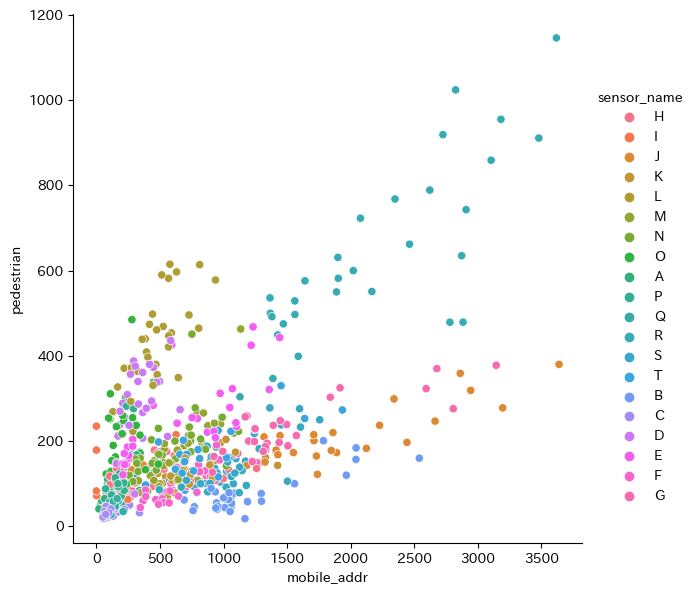

In [2]:
df = pd.read_csv("data/data4mixed_model.csv")
sns.pairplot(x_vars=['mobile_addr'], y_vars=['pedestrian'], data=df, hue='sensor_name', height=6)

ひとつの曲線を引くには無理である。視覚的には、3つのカテゴリに分けられるように見える。

このデータに対して混合線形回帰を適用してみる。



## 条件付き混合線形回帰


PRMLテキスト14章のモデル

https://qiita.com/ctgk/items/3f7e9b37e9bc81b5c063

のプログラム例を修正拡張し、上記のサンプルデータに対して「条件付き混合線形回帰」を試す。

これは、EM(Expectation-Maximization)アルゴリズムと呼ばれる、クラス分けの手法を回帰に応用したもので、この分離アルゴリズムとベイズ流の線形回帰をうまく組み合わせて用いる手法といえる。



In [3]:
# ライブラリのインポート
import itertools
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import numpy as np

### 条件付き混合線形回帰を行う関数の定義

上記ページの変型版をつくる。

(注)
- 計画行列は、説明変数の各データを1行として、縦に並べたもの。
  
- 1列目は定数項とするので1を並べる。
  
- 説明変数が1個の場合は、データ数を$N$とすると$N$行2列の行列になる。

In [54]:
# 計画行列(design matrix)の作成
# 特徴ベクトル（一つのデータ)を１行とし、各データを縦に並べた行列
from functools import reduce
class PolynomialFeatures(object):

    def __init__(self, degree=2):
        assert isinstance(degree, int)
        self.degree = degree

    def transform(self, x):
        if x.ndim == 1:
            x = x[:, None]
        x_t = x.transpose()
        features = [np.ones(len(x))]
        for degree in range(1, self.degree + 1):
            for items in itertools.combinations_with_replacement(x_t, degree):
                features.append(reduce(lambda x, y: x * y, items))
        return np.asarray(features).transpose()

In [55]:
import copy
# 条件付き混合線形回帰の本体
class ConditionalMixtureModel(object):

    def __init__(self, n_models=2):
        # モデルの個数を指定
        self.n_models = n_models

    # 最尤推定を行うメソッド
    def fit(self, X, t, n_iter=100):
        # 推定したいパラメータ（重み係数、混合係数、分散）の初期化
        coef = np.linalg.pinv(X).dot(t)
        print(coef)
        self.coef = coef + np.random.normal(size=len(coef))
        for i in range(self.n_models - 1): # バグ修正 (3以上のモデル数に対応)
            self.coef = np.vstack((self.coef,
                                   coef + np.random.normal(size=len(coef))))
        self.coef = self.coef.T
        self.var = np.mean(np.square(X.dot(coef) - t))
        self.weight = np.ones(self.n_models) / self.n_models
        self.rec_coef = [{'step':0, 'coef': copy.deepcopy(self.coef)}]

        # EMステップを指定した回数だけ繰り返す
        for i in range(n_iter):
            # Eステップ 負担率E[z_nk]を各データ、各モデルごとに計算
            self.resp = self._expectation(X, t)          
            # Mステップ パラメータについて最大化
            self._maximization(X, t, self.resp)
            # 係数の履歴を記録
            self.rec_coef.append({'step': i+1, 'coef': copy.deepcopy(self.coef)})  
    # ガウス関数
    def _gauss(self, x, y):
        return np.exp(-(x - y) ** 2 / (2 * self.var))

    # Eステップ 負担率gamma_nk=E[z_nk]を計算
    def _expectation(self, X, t):
        # PRML式(14.37)
        # print(X.dot(self.coef))
        responsibility = self.weight * self._gauss(X.dot(self.coef), t[:, None])
        responsibility /= np.sum(responsibility, axis=1, keepdims=True)
        return responsibility

    # Mステップ パラメータについて最大化
    def _maximization(self, X, t, resp):
        # PRML式(14.38) 混合係数の計算
        self.weight = np.mean(resp, axis=0)
        for m in range(self.n_models):
            # PRML式(14.42) 各モデルごとに係数を計算
            self.coef[:, m] = np.linalg.inv((X.T * resp[:, m]).dot(X)).dot(X.T * resp[:, m]).dot(t)

        # PRML式(14.44) 分散の計算
        self.var = np.mean(
            np.sum(resp * np.square(t[:, None] - X.dot(self.coef)), axis=1))

    def predict(self, X):
        return X.dot(self.coef)
    
    def getResponsibility(self):
        return self.resp

### サンプルデータの作成とテスト

#### サンプルデータの作成

- ２つの混合データをつくる関数 create_toy_data
- 上記を変形して傾きが異なる３種類のデータを作る関数 create_toy_data2

In [6]:
# サンプルデータ作成関数 (オリジナル版)
def create_toy_data(sample_size=20, std=0.1):
    x = np.linspace(-1, 1, sample_size)
    y = (x > 0.).astype(np.float) * 2 - 1
    y = x * y
    y += np.random.normal(scale=std, size=sample_size)
    return x, y

In [7]:
# サンプルデータ作成関数 その2 (3種類データ)
def create_toy_data2(sample_size=30, std=0.2):
    x = np.linspace(0, 3, sample_size)
    x = np.hstack((x,np.linspace(0, 3, sample_size)))
    x = np.hstack((x,np.linspace(0, 3, sample_size)))
    y = np.zeros(sample_size*3)
    y[:sample_size] = x[:sample_size] + 0.1
    y[sample_size: sample_size*2] = 2.0* x[sample_size: sample_size*2] -0.5
    y[sample_size*2:] = 3.0 * x[sample_size*2:]
    y += np.random.normal(scale=std, size=sample_size*3)
    return x, y

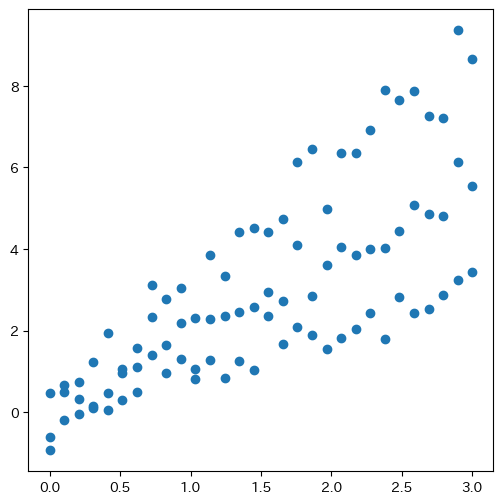

In [8]:
x_train,y_train = create_toy_data2(30, std=0.5)
plt.figure(figsize=(6,6))
plt.scatter(x_train,y_train)

#### サンプルデータへの条件付き混合モデルの適用

モデルの数（何種類の混合とみるか）はハイパーパラメータとしてあたえる必要がある。

- create_toy_dataでは2種類を想定しているので、n_modelsは2, create_toy_data2では3
- 試しに、create_toy_data2で作ったものをn_model=2で計算してみてもよい。
- 描画の色指定は２種類あるいは３種類の場合にしか対応してないことの注意 (それ以上の場合は、各自で工夫してください。)


In [ ]:
list(test_single[:,0]+first_year)

[-1.55110069e-03  1.95391914e+00]


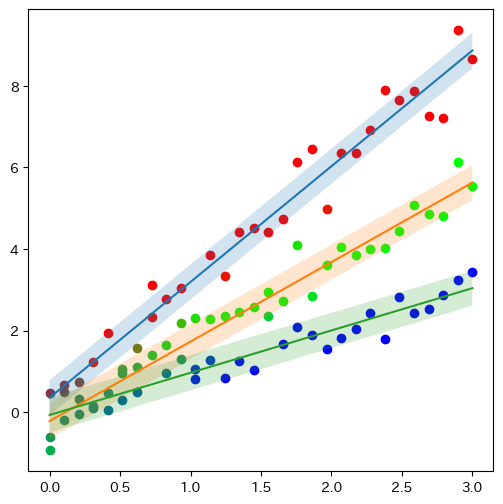

In [11]:
import math

# PolynomialFeaturesはべき基底関数をつくるための関数！
# たとえば、degree=2とすると、y = a x + b x**2 のような2次式のフィッティングを行うために、1, x, x**2を列とする(N,3)行列の計画行列になる
# 本研究の場合は線形なのでdegree=1

feature = PolynomialFeatures(degree=1)
X_train = feature.transform(x_train)

# 条件付き混合モデルの用意（モデル数を指定) 
n_models = 3
model = ConditionalMixtureModel(n_models=n_models)

# 学習：パラメータの最尤推定を行う
model.fit(X_train, y_train,n_iter=500)

# 予測
x = np.linspace(0, 3, 100)
X = feature.transform(x)
Y = model.predict(X)

# Figureの初期化
fig = plt.figure(figsize=(6, 6))
# Figure内にAxesを追加()
ax = fig.add_subplot(111) #...2

# トレーニングデータの描画
for i, c in enumerate(model.getResponsibility()): # データ点ごとに負担率(responsibility)で色付け描画
    if len(c) == 2:
        color = [c[0], c[1], 0]
    else:
        color = c
    ax.scatter([x_train[i]], [y_train[i]], color=color)

# 回帰線の描画
for i in range(n_models):
    ax.plot(x, Y[:, i])

# 標準偏差の幅で色付けしてみる
std_dev = math.sqrt(model.var)
for i in range(n_models):
    ax.fill([x[0],x[0],x[-1],x[-1]],
            [Y[0,i]-std_dev, Y[0,i]+std_dev, Y[-1,i]+std_dev, Y[-1,i]-std_dev], alpha=0.2)
plt.show()

データ点をクラスごとに色付けしてある。複数のクラスに属しているデータ点は混合した色になっている。各点がどのクラスに属するかのウェートは負担率(responsibility)と呼ばれる。

## 実践的な事例




In [125]:
df = pd.read_csv("data/data4mixed_model.csv")
df.head()

sensor_name      date  hour  mobile_addr  pedestrian
0           H  20181130    10          144          67
1           H  20181130    11          239          90
2           H  20181130    12          173         110
3           H  20181130    13          184          70
4           H  20181130    14          277          89

### データの散布図

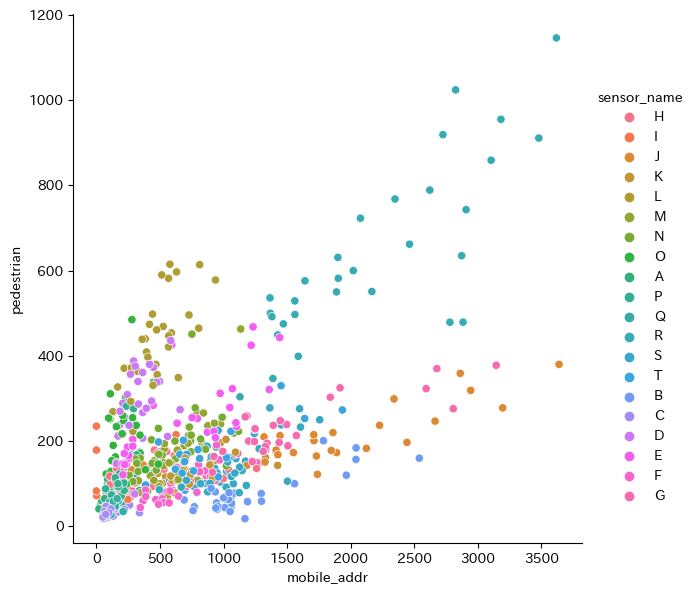

In [55]:
sns.pairplot(x_vars=['mobile_addr'], y_vars=['pedestrian'], data=df, hue='sensor_name', height=6)

２０地点のデータであるが、関係は３つにカテゴライズできそうに見える。
そこで、３種類の混合線形モデルとして分析してみる

### 混合線形モデルによる分析

負担率を色で表示 (seabornでの表示は今後)

In [126]:
import math

x_train = df['mobile_addr'].values
y_train = df['pedestrian'].values

# 特徴ベクトルの定義（次数1）
feature = PolynomialFeatures(degree=1)

# 計画行列への変換
X_train = feature.transform(x_train)
#print(X_train)

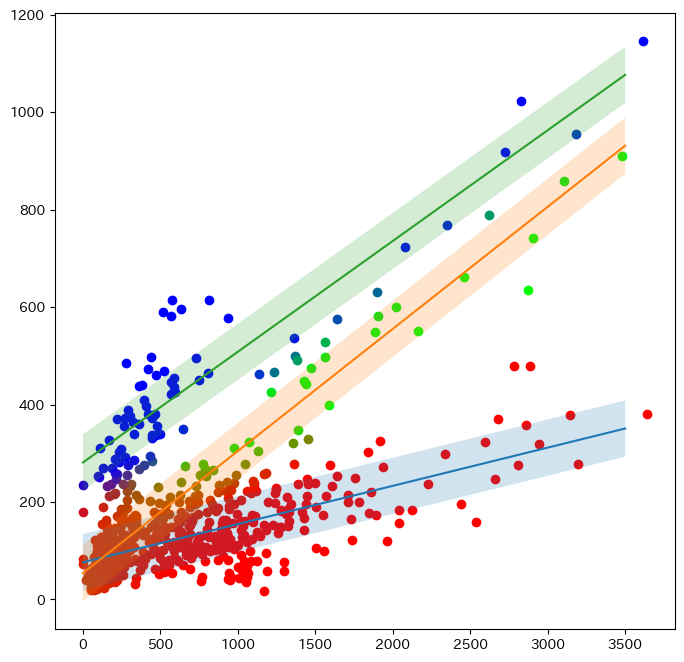

[[7.62914484e+01 5.40527021e+01 2.81175125e+02]
 [7.84904007e-02 2.50731834e-01 2.27399650e-01]]
3334.588704964099


In [59]:
# 条件付き混合モデルの用意（モデル数3) 
model = ConditionalMixtureModel(n_models=3)

# パラメータの最尤推定を行う
model.fit(X_train, y_train,n_iter=500)

# 結果を図示
x = np.linspace(0, 3500, 200)
X = feature.transform(x)
Y = model.predict(X)
# Figureの初期化
fig = plt.figure(figsize=(8, 8))
# Figure内にAxesを追加()
ax = fig.add_subplot(111) #...2

for i, c in enumerate(model.getResponsibility()): # データ点ごとに負担率(responsibility)で色付け描画
    ax.scatter([x_train[i]], [y_train[i]], color=c)

# 回帰線の描画
ax.plot(x, Y[:, 0])
ax.plot(x, Y[:, 1])
ax.plot(x, Y[:, 2])
std_dev = math.sqrt(model.var)
# 標準偏差の幅で色付けしてみる
ax.fill([x[0],x[0],x[-1],x[-1]],
        [Y[0,0]-std_dev, Y[0,0]+std_dev, Y[-1,0]+std_dev, Y[-1,0]-std_dev], alpha=0.2)
ax.fill([x[0],x[0],x[-1],x[-1]],
        [Y[0,1]-std_dev, Y[0,1]+std_dev, Y[-1,1]+std_dev, Y[-1,1]-std_dev], alpha=0.2)
ax.fill([x[0],x[0],x[-1],x[-1]],
        [Y[0,2]-std_dev, Y[0,2]+std_dev, Y[-1,2]+std_dev, Y[-1,2]-std_dev], alpha=0.2)
plt.show()
print(model.coef) # 回帰係数
print(model.var)  # 分散
# print(model.getResponsibility())

上記のプログラムを繰り返し実行すると、実行ごとに結果が変化することが見て取れるだろう。つまり、最大尤度に到達していないのである。これは単純に反復計算数を増やすことでは解決しない。３つのカテゴリに分けることが本質的に困難なデータであるのか、尤度最大を見つける方法に工夫が必要なのかは未解明である。

また、ガウス分布の分散が一定であるという仮定にも問題があることを指摘しておく。

(実際の研究には、この方法ではなく、センサごとにクラス分けした階層線形モデルが用いられた。)

## 実践的な例２：甲府の気温データ

初回の導入に事例として用いた甲府市の年間気温の推移は、ある時期を境に変化が質的に変わっているのではないかと考え、混合モデルを適用してみる。

個々で作成したConditionalMixtureModelを用いる際には、適当なデータのスケール変換をしないと、数値オーバーフローが起きる。


In [33]:
import pandas as pd
df_temperature = pd.read_csv("data/temperature_data_kofu.csv")
df_temperature.head()

年月  平均気温(℃)
0  1895/1      0.2
1  1895/2      1.0
2  1895/3      7.2
3  1895/4     12.7
4  1895/5     17.4

In [34]:
df_temperature['date'] = pd.to_datetime(df_temperature['年月'])
df_temperature['year'] = df_temperature['date'].dt.year
# 1920以降のデータを採用
df_temperature = df_temperature[df_temperature['year']>=1920]
df_temperature.head()

年月  平均気温(℃)       date  year
300  1920/1/1      2.5 1920-01-01  1920
301  1920/2/1      2.0 1920-02-01  1920
302  1920/3/1      7.2 1920-03-01  1920
303  1920/4/1     13.1 1920-04-01  1920
304  1920/5/1     17.5 1920-05-01  1920

<AxesSubplot: xlabel='year'>

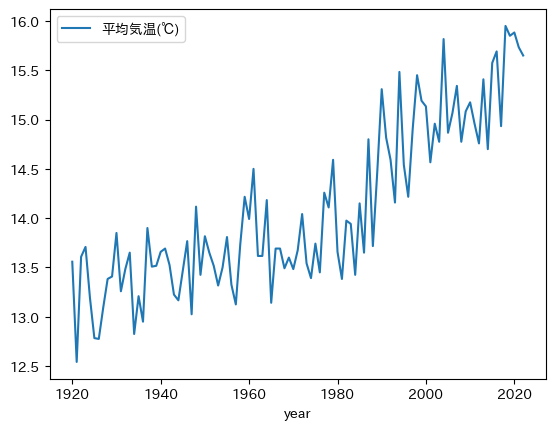

In [35]:
df_annual = df_temperature[["year","平均気温(℃)"]].groupby('year').mean().reset_index()
df_annual = df_annual[df_annual["year"]!=1945]
df_annual.plot(x="year", y="平均気温(℃)")

次の例では、1910年から2022年までのデータに限り、温度のスケール変換を行ってから学習、評価し、結果をもとのスケールに戻している。

In [77]:
import math
import numpy as np

n_models=2
# スケール変換 (切片が0付近でないと数値エラーになる。ガウシアンの計算上において)
syear = 1910
eyear = 2025
base_temp = 12.0
scaler_temp = 10.0

x_train = df_annual['year'].values - syear
y_train = (df_annual['平均気温(℃)'].values - base_temp)*scaler_temp
   
# 特徴ベクトルの定義（次数1）
feature = PolynomialFeatures(degree=1)
# 計画行列への変換
X_train = feature.transform(x_train)

In [78]:
# 条件付き混合モデルの用意（モデル数2) 
model = ConditionalMixtureModel(n_models=n_models)
# パラメータの最尤推定を行う
model.fit(X_train, y_train,n_iter=1000)

# 結果を図示
x = np.linspace(0, eyear - syear, int(eyear - syear))
X = feature.transform(x)
Y = model.predict(X)

# print(y_train)

[6.33362827 0.23927175]


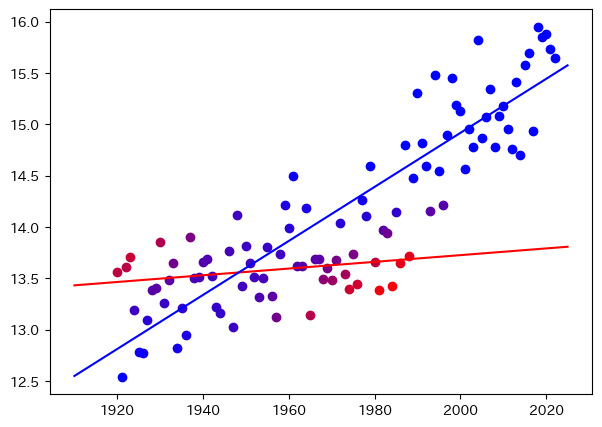

[[14.32098097  5.49560094]
 [ 0.03267888  0.26301454]]
12.686178557963


In [79]:
# Figureの初期化
fig = plt.figure(figsize=(7, 5))
# Figure内にAxesを追加()
ax = fig.add_subplot(111) #...2

for i, c in enumerate(model.getResponsibility()): # データ点ごとに負担率(responsibility)で色付け描画
    if len(c) == 2:
        color = [c[0], 0, c[1]]
    else:
        color = c
    ax.scatter([x_train[i]+syear], [y_train[i]/scaler_temp + base_temp], color=color)

# 回帰線の描画
ax.plot(x+syear, Y[:, 0]/scaler_temp + base_temp, "r-")
ax.plot(x+syear, Y[:, 1]/scaler_temp + base_temp, "b-")

#ax.plot(x, Y[:, 2])
std_dev = math.sqrt(model.var)
# 標準偏差の幅で色付けしてみる
#ax.fill([x[0],x[0],x[-1],x[-1]],
#        [Y[0,0]-std_dev, Y[0,0]+std_dev, Y[-1,0]+std_dev, Y[-1,0]-std_dev], alpha=0.2)
#ax.fill([x[0],x[0],x[-1],x[-1]],
#        [Y[0,1]-std_dev, Y[0,1]+std_dev, Y[-1,1]+std_dev, Y[-1,1]-std_dev], alpha=0.2)
#ax.fill([x[0],x[0],x[-1],x[-1]],
#        [Y[0,2]-std_dev, Y[0,2]+std_dev, Y[-1,2]+std_dev, Y[-1,2]-std_dev], alpha=0.2)
plt.show()
print(model.coef) # 回帰係数
print(model.var)  # 分散
# print(model.getResponsibility())

## 方法についての概念的解説

重み(線形回帰の係数:切片と傾き) ${\bf w}_k$で定義される$K$個の線形回帰モデルを考える。データの確率分布は、$K$個の直線の周りにガウス分布すると仮定するのである。

$k$個のモデルの重みを$\pi_k$とし、ガウス分布の分散を$\beta^{-1}$とすると、目的変数の確率分布は
$$
  p(t|{\bf \theta}) = \sum_1^{k} \pi_k \cal{N}(t| {\bf w}_k^T{\bf \phi}, \beta^{-1})
$$
と書くことができる。$\cal{N}$はガウス分布であり、左辺の${\bf \theta}$は、これから決めるパラメータ${\bf w}_k$、$\pi_k$、$\beta$の総称である。

![概要図](https://8tops.yamanashi.ac.jp/~toyoki/labTips/dataScience/images/mixedLM1.png)

観測値$\{{\bf \phi}_n, t_n\}$ ($n=1,\cdots, N$) が与えられたときの対数尤度関数(そのようなデータが現れる尤もらしさの対数)は

$$
  \ln p({\bf t}|{\bf \theta}) = \sum_{n=1}^{N} \ln \left[
     \sum_{k=1}^K \pi_k \cal{N} (t_n | {\bf w}_k^T{\bf \phi}, \beta^{-1})
  \right]
$$

のように表される。


３種のパラメータを、EM法 (Expectation-Maximization method)できめる。EM法は、<span class="burk">Eステップ</span>と<span class="burk">Mステップ</span>の２段階からなり、それを繰り返して尤度が最大になるパラメータを求める。

最初に、上の図の回帰直線の初期値をセットし、データ点に基づいて以下の2段階の最適化を行う。

- **Eステップ** 各データ点の負担率(responsibility)の更新
 - 与えられた$\{{\bf w}_k\}$、$\beta$について、各データ点がどちらの直線に近いかの割合（負担率）を決める。
 - 負担率を変数として含む対数尤度関数の表式を負担率で微分した式がゼロとなる（つまり極値をとる）条件を解いて「負担率＝」の形に表した式。(テキストの(14.37)式)から計算する。

- **Mステップ** 分布のパラメータ${\bf \theta}$を更新する。
 - 負担率を固定した対数尤度関数について、それぞれのパラメータで微分した式がゼロとする式を解いて得られる、「パラメータ＝」の表式(テキスト(14.38), (14.42), (14.44)式) から計算する。

ここで用いているクラスConditionalMixtureModelでは、この２ステップを繰り返して、最適なパラメータ値を求めている。繰り返しは３０ステップくらいで定常値に到達するようである。

最適値を求める式は、対数尤度関数をそれぞれのパラメータで微分した値がゼロになる条件（つまり極値をとる条件）から導出しているので、グローバルな最大値にはならず、あくまでも局所的な最大値にしか到達しない。つまり、一般には初期値に依存してしまう。そこで、初期値を乱数で与え、もっとも良い結果（$\beta^{-1}$が小さくなるもの）を与える回帰係数を探す。


### 詳細

#### Eステップ

各データについて分担率を決めるために、2値潜在変数${\bf z}_n= \{ z_{n1}, z_{n2}, \cdots , z_{nK}\}$を導入する。$k= 1, \cdots, K$のうちどれか一つだけが$1$となり、他は0である。${\bf Z} = \{{\bf z}_n\}$をパラメータとして含む対数尤度関数は

$$
\ln p({\bf t},{\bf Z}|{\bf \theta}) = \sum_{n=1}^{N} \sum_{k=1}^{K} z_{nk} \ln \left[
     \sum_{k=1}^K \pi_k \cal{N} (t_n | {\bf w}_k^T{\bf \phi}, \beta^{-1})
  \right]
$$

初期のパラメータを${\bf \theta}^{{\rm old}}$のもとでの$z_{nk}$の期待値として分担率を求める：

$$
   \gamma_{nk} = \mathbb{E}[z_{nk}] = p(k| {\bf \phi}_n, {\bf \theta}^{{\rm old}})
   = \frac{\pi_k \cal{N}(t_n| {\bf w}_k^T {\bf \phi}, \beta^{-1})}
   {\sum_{j} \pi_j \cal{N}(t_n| {\bf w}_k^T{\bf \phi}, \beta^{-1})}
$$

決定した分担率のもとでの対数尤度の期待値を

$$
 Q({\bf \theta}, {\bf \theta}^{{\rm old}}) = \mathbb{E}_{\bf Z} \left[ \ln p ({\bf t}, {\bf Z}| {\bf \theta}) \right]
 = \sum_{n=1}^N \sum_{k=1}^K \gamma_{nk} \left\{ \ln \pi_{k} + \ln \cal{N}(t_n| {\bf w}_k^{\rm T}{\bf \phi}_n, \beta^{-1} \right\}
$$

#### Mステップ

$Q({\bf \theta}, {\bf \theta}^{{\rm old}})$の各パラメータでの微分をゼロとした式より、パラメータ値を求める。
